# Le PIB est-il un indicateur robuste de l'accès à l'alimentation ?

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Partie 1 : Collecte des données

### Récupération des données de PIB à partir de la base de données de la banque mondiale

In [4]:
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.KD?format=json&per_page=20000"


response = requests.get(url)

# Extraction du JSON de la réponse
PIB_hab = response.json()  # ici c’est correct

# Vérification des données
print(type(PIB_hab),len(PIB_hab))
print(PIB_hab[0]) # Métadonnées
print(PIB_hab[1][:5]) # Données de PIB par pays


<class 'list'> 2
{'page': 1, 'pages': 1, 'per_page': 20000, 'total': 17290, 'sourceid': '2', 'lastupdated': '2025-12-04'}
[{'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2024', 'value': 1416.25036869408, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2023', 'value': 1412.62538438423, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2022', 'value': 1421.79716897878, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 

#Retraitement des données


Suppression des colonnes inutiles

In [44]:
donnees = PIB_hab[1]  # On ne garde pas les métadonnées

# On transforme le JSON en DataFrame et on ne garde que le PIB/hab pour chaque années avec le nom et le code du pays
liste_simplifiee = []
for item in donnees:
    nom_pays = item['country']['value']  # nom complet du pays
    annee = int(item['date'])
    pib = item['value']
    liste_simplifiee.append({'nom_pays': nom_pays, 'année': annee, 'PIB_par_habitant': pib})

PIB_hab_simple = pd.DataFrame(liste_simplifiee)

# Filtrer uniquement les années de 1960 à 2022. 
PIB_hab_simple = PIB_hab_simple[(PIB_hab_simple['année'] >= 2000) & (PIB_hab_simple['année'] <= 2024)]

# Afficher les 5 premières lignes
print(PIB_hab_simple.head(200))
PIB_hab_simple.loc[PIB_hab_simple['nom_pays'] == 'Russia']

                                        nom_pays  année  PIB_par_habitant
0                    Africa Eastern and Southern   2024       1416.250369
1                    Africa Eastern and Southern   2023       1412.625384
2                    Africa Eastern and Southern   2022       1421.797169
3                    Africa Eastern and Southern   2021       1409.040699
4                    Africa Eastern and Southern   2020       1383.724119
..                                           ...    ...               ...
475  East Asia & Pacific (excluding high income)   2004       2835.250834
476  East Asia & Pacific (excluding high income)   2003       2618.816094
477  East Asia & Pacific (excluding high income)   2002       2422.476717
478  East Asia & Pacific (excluding high income)   2001       2259.818286
479  East Asia & Pacific (excluding high income)   2000       2132.394104

[200 rows x 3 columns]


,nom_pays,année,PIB_par_habitant


Filtrage pour enlever les pays contenant des valeurs manquantes

In [6]:
#PIB_hab_simple_sans_NA = PIB_hab_simple.dropna()
#print(len(PIB_hab_simple['nom_pays'])/(2022-1960+1),len(PIB_hab_simple_sans_NA['nom_pays'])//(2022-1960+1)) # On a enlevé 48 pays ou groupe de pays de la liste

Restriction aux pays suivants : France, Etats-unis, Angleterre, Russie, Chine, Japon, Brésil, Afrique du Sud

In [45]:
# Liste des pays à conserver
pays_a_conserver = [
    'India', 'China', 'Brazil', 'South Africa', 'Russian Federation', 'Mexico'
]

# Filtrer le DataFrame
PIB_hab_BRICSAM = PIB_hab_simple[PIB_hab_simple['nom_pays'].isin(pays_a_conserver)]

# Vérifier le résultat
print(PIB_hab_BRICSAM['nom_pays'].unique())
print(PIB_hab_BRICSAM.head(126))

['Brazil' 'China' 'India' 'Mexico' 'Russian Federation' 'South Africa']
                 nom_pays  année  PIB_par_habitant
4875               Brazil   2024       9564.576077
4876               Brazil   2023       9288.027015
4877               Brazil   2022       9032.084816
4878               Brazil   2021       8799.229458
4879               Brazil   2020       8435.011433
...                   ...    ...               ...
13671  Russian Federation   2003       6370.453613
13672  Russian Federation   2002       5910.171875
13673  Russian Federation   2001       5618.955566
13674  Russian Federation   2000       5323.666504
14690        South Africa   2024       5708.964422

[126 rows x 3 columns]


Gestion des valeurs manquantes

In [46]:
for pays in PIB_hab_BRICSAM['nom_pays'].unique() :
    print(PIB_hab_BRICSAM.loc[PIB_hab_BRICSAM['nom_pays'] == pays].isna().sum(),pays)

nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Brazil
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 China
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 India
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Mexico
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Russian Federation
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 South Africa


### Récupération des données indicateurs alimentaires à partir de la base de données FAOSTAT

In [6]:
pip install faostat

Note: you may need to restart the kernel to use updated packages.


In [1]:
import faostat

df = faostat.list_datasets_df() # cette fonction permet de récupérer l'ensemble des indicateurs disponible
                                    # ainsi que d'avoir des informations sur les màj de versions, etc
print(df)

   code                              label date_update     note_update  \
0   QCL       Crops and livestock products  2025-06-11  minor revision   
1    QI                 Production Indices  2025-02-03                   
2    QV   Value of Agricultural Production  2025-02-03                   
3    FS  Suite of Food Security Indicators  2025-07-28                   
4   FBS              Food Balances (2010-)  2025-10-28                   
..  ...                                ...         ...             ...   
63   FA           Food Aid Shipments (WFP)  2016-12-22                   
64   RM                          Machinery  2021-12-03  minor revision   
65   RY                  Machinery Archive  2021-12-03  minor revision   
66   RA                Fertilizers archive  2020-09-08  minor revision   
67   PA       Producer Prices (old series)  1991-12-31                   

            release_current state_current year_current release_next  \
0   2024-12-20 / 2025-06-11         fina

In [3]:
print(faostat.list_pars_df('FS'))
print(np.sort(faostat.get_par_df('FS', 'countries')))
print(faostat.get_par_df('FS', 'year3'))
print(faostat.get_par_df('FS', 'element'))
print(faostat.get_par_df('FS', 'item'))
print(faostat.get_par_df('FS', 'area'))

  parameter code          coding_systems  \
0           area  [M49, FAO, ISO2, ISO3]   
1        element                      []   
2           item                      []   
3          year3                      []   

                       subdimensions {code: meaning}  
0  {'countries': 'Countries', 'regions': 'Regions...  
1                           {'elements': 'Elements'}  
2                                 {'items': 'Items'}  
3                                {'years3': 'Years'}  
[['0' '2' 'Afghanistan']
 ['0' '3' 'Albania']
 ['0' '4' 'Algeria']
 ['0' '5' 'American Samoa']
 ['0' '6' 'Andorra']
 ['0' '7' 'Angola']
 ['0' '8' 'Antigua and Barbuda']
 ['0' '9' 'Argentina']
 ['0' '1' 'Armenia']
 ['0' '10' 'Australia']
 ['0' '11' 'Austria']
 ['0' '52' 'Azerbaijan']
 ['0' '12' 'Bahamas']
 ['0' '13' 'Bahrain']
 ['0' '16' 'Bangladesh']
 ['0' '14' 'Barbados']
 ['0' '57' 'Belarus']
 ['0' '255' 'Belgium']
 ['0' '23' 'Belize']
 ['0' '53' 'Benin']
 ['0' '17' 'Bermuda']
 ['0' '18' 'Bhutan']

***On utilise la fonction définie dans le fichier py import des données faostat pour récupérer les données de 4 indicateurs  pour les pays des BRICSAM sur la période 2000 à 2022.***
Les indicateurs sont : 
"suffisance des apports énergétiques alimentaires moyens"
"disponibilité alimentaire par habitant"
"disponibilité protéiques moyenne"
"prévalence de la sous alimentation"


In [6]:
from import_fao import get_datas_fao

In [ ]:

liste_pays = [202,185,138,100,351,21] # Correspond aux codes des pays des BRICSAM

data_faostat = get_datas_fao(liste_pays)

print(data_faostat.head(10))



     Pays                                         Indicateur Année Unité  \
0  Brazil  suffisance des apports énergétiques alimentair...  2000     %   
1  Brazil  suffisance des apports énergétiques alimentair...  2001     %   
2  Brazil  suffisance des apports énergétiques alimentair...  2002     %   
3  Brazil  suffisance des apports énergétiques alimentair...  2003     %   
4  Brazil  suffisance des apports énergétiques alimentair...  2004     %   
5  Brazil  suffisance des apports énergétiques alimentair...  2005     %   
6  Brazil  suffisance des apports énergétiques alimentair...  2006     %   
7  Brazil  suffisance des apports énergétiques alimentair...  2007     %   
8  Brazil  suffisance des apports énergétiques alimentair...  2008     %   
9  Brazil  suffisance des apports énergétiques alimentair...  2009     %   

  Valeur  
0    122  
1    124  
2    127  
3    129  
4    130  
5    131  
6    132  
7    133  
8    134  
9    136  


On améliore la visibilité du dataset en enlevant les colonnes qui ne nous serviront pas et en renommant certaines colonnes.

In [ ]:
"""data_faostat = data_faostat.drop(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Element', 'Year Code','Item Code'], axis=1)
data_faostat = data_faostat.rename(columns={
    'Item': 'Indicateur',
    'Area': 'Pays',
    'Year': 'Année',
    'Unit' : 'Unité',
    'Value' : 'Valeur'
})
print(data_faostat.head())"""


     Pays                                         Indicateur      Année Unité  \
0  Brazil  Average dietary energy supply adequacy (percen...  2000-2002     %   
1  Brazil  Average dietary energy supply adequacy (percen...  2001-2003     %   
2  Brazil  Average dietary energy supply adequacy (percen...  2002-2004     %   
3  Brazil  Average dietary energy supply adequacy (percen...  2003-2005     %   
4  Brazil  Average dietary energy supply adequacy (percen...  2004-2006     %   

  Valeur  
0    122  
1    124  
2    127  
3    129  
4    130  


On vérifie ensuite qu'il n'y a pas de valeurs manquantes dans nos données. Comme ce n'est pas le cas, nous n'avons pas besoin de passer par un retraitement.

In [ ]:
print(data_faostat.isna().sum())

Pays          0
Indicateur    0
Année         0
Unité         0
Valeur        0
dtype: int64


Les indicateurs de notre jeu de données n'ont pas été calculés par année mais en réalisant une moyenne sur 3ans. Nous avons donc la moyenne sur la période 2000-2002 puis 2001-2003, etc. Afin de faciliter la modélisation avec les données de PIB par habitants (disponible, elles, par année), nous avons conclus que le choix le plus adapté était, pour chaque moyenne sur 3ans, d'attribuer cette valeur à la première année. Par exemple : si nous avons la moyenne sur 2011-2013, nous attribuons cette valeur à l'année 2011. Cela permet de garder les mêmes tendances. Par contre, en cas de choc sur le PIB par habitant sur une année, le calcul en moyenne risque de lisser ce choc sur les indicateurs alimentaires. Cela pourrait rendre nos résultats moins robustes.

In [ ]:
"""for year in data_faostat['Année'].unique():
    # Pour l'instant la valeur de year s'écrit 'xxxx-yyyy'. Comme on ne veut garder que la première année ('xxxx'). 
    # On ne garde que les 4 premiers caractères. On les passaes ensuite en entier.
    data_faostat.loc[data_faostat['Année'] == year, 'Année'] = int(year[:4])

print(data_faostat.head())"""

TypeError: 'int' object is not subscriptable

On modifie le nom des indicateurs pour plus de lisibilité

In [ ]:
"""for indicateur in data_faostat['Indicateur']:
    if indicateur == 'Average dietary energy supply adequacy (percent) (3-year average)':
        data_faostat.loc[data_faostat['Indicateur'] == indicateur, 'Indicateur'] = "suffisance des apports énergétiques alimentaires moyens"

    elif indicateur == 'Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day) (3-year average)':
        data_faostat.loc[data_faostat['Indicateur'] == indicateur, 'Indicateur'] = "disponibilité alimentaire par habitant"

    elif indicateur == 'Average protein supply (g/cap/day) (3-year average)':
        data_faostat.loc[data_faostat['Indicateur'] == indicateur, 'Indicateur'] = "disponibilité protéiques moyenne"

    elif indicateur == 'Prevalence of undernourishment (percent) (3-year average)':
        data_faostat.loc[data_faostat['Indicateur'] == indicateur, 'Indicateur'] = "prévalence de la sous alimentation"

# Afficher le résultat
print(data_faostat.head())"""

     Pays                                         Indicateur Année Unité  \
0  Brazil  suffisance des apports énergétiques alimentair...  2000     %   
1  Brazil  suffisance des apports énergétiques alimentair...  2001     %   
2  Brazil  suffisance des apports énergétiques alimentair...  2002     %   
3  Brazil  suffisance des apports énergétiques alimentair...  2003     %   
4  Brazil  suffisance des apports énergétiques alimentair...  2004     %   

  Valeur  
0    122  
1    124  
2    127  
3    129  
4    130  


In [15]:
print(data_faostat['Unité'].unique())
print(data_faostat)

['%' 'kcal/cap/d' 'g/cap/d']
             Pays                                         Indicateur Année  \
0          Brazil  suffisance des apports énergétiques alimentair...  2000   
1          Brazil  suffisance des apports énergétiques alimentair...  2001   
2          Brazil  suffisance des apports énergétiques alimentair...  2002   
3          Brazil  suffisance des apports énergétiques alimentair...  2003   
4          Brazil  suffisance des apports énergétiques alimentair...  2004   
..            ...                                                ...   ...   
535  South Africa                 prévalence de la sous alimentation  2018   
536  South Africa                 prévalence de la sous alimentation  2019   
537  South Africa                 prévalence de la sous alimentation  2020   
538  South Africa                 prévalence de la sous alimentation  2021   
539  South Africa                 prévalence de la sous alimentation  2022   

    Unité Valeur  
0       %    12

## Partie 2 : DATA VISUALIZATION

Evolutions des PIB/HAB

In [33]:
for pays in PIB_hab_BRICSAM['nom_pays'].unique() :
    PIB_hab_pays=PIB_hab_BRICSAM.loc[PIB_hab_BRICSAM['nom_pays'] == pays]
    plt.plot(PIB_hab_pays['année'],PIB_hab_pays['PIB_par_habitant'],label=pays)

plt.xlabel('Année')    
plt.ylabel('PIB par habitant ($ US courants)')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

NameError: name 'PIB_hab_BRICSAM' is not defined

Illustrations indicateurs

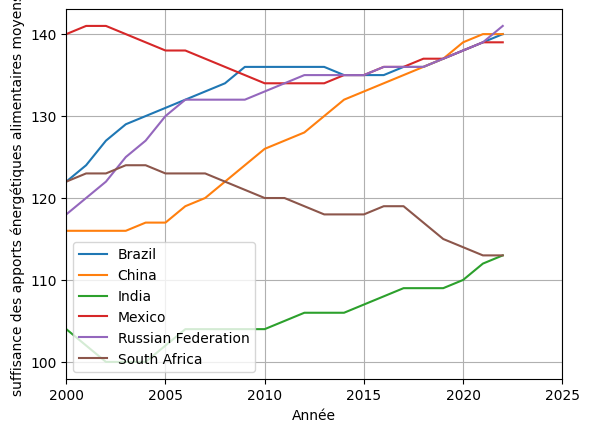

In [9]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='suffisance des apports énergétiques alimentaires moyens']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('suffisance des apports énergétiques alimentaires moyens')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

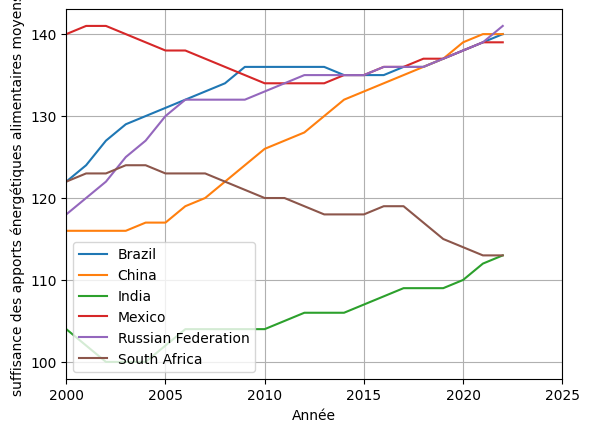

In [13]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='suffisance des apports énergétiques alimentaires moyens']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('suffisance des apports énergétiques alimentaires moyens')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

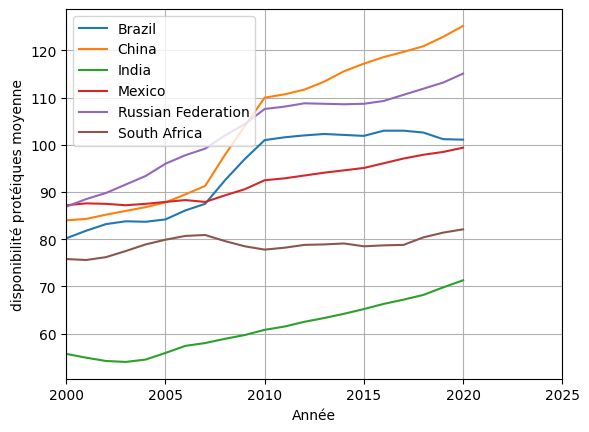

In [12]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='disponibilité protéiques moyenne']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('disponibilité protéiques moyenne')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

ValueError: could not convert string to float: '<2.5'

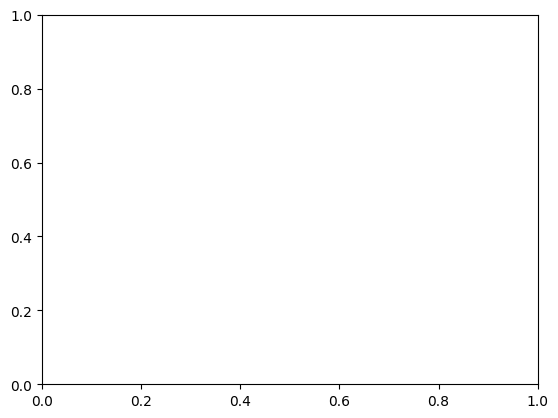

In [11]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='prévalence de la sous alimentation']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('prévalence de la sous alimentation')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

## Partie 3 : MODELE

### ACP

In [13]:

import faostat
import pandas as pd
df = faostat.list_datasets_df()
list = []
for i in range(67):
    list.append(df.iloc[i,0:2])
    print(list[i])
liste_pays = [21,68,100,110,185,229,231,351] # dans l'ordre : Brazil, ...

mypars = {'area': liste_pays,
              'element': [6120],
              'item': ['21010','22000','21013','210104','22013','210401','21031'],
              'year': [1999, 2025]}
data_faostat = faostat.get_data_df('FS', pars=mypars, strval=False)
data_faostat.head(100)
data_faostat = data_faostat.drop(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Element', 'Year Code', 'Item Code'], axis=1)
data_faostat = data_faostat.rename(columns={'Item': 'Indicateur'})
# Récupérer les noms d’indicateurs correspondant aux codes que tu veux
items_acp = ['21010','22000','21013','210104','210401','21031']

# On repart depuis les données AVANT suppression de 'Item Code'
# Donc recharge les données brutes :
data_faostat_raw = faostat.get_data_df('FS', pars=mypars, strval=False)

# Sélection uniquement des items que tu veux
data_items = data_faostat_raw[data_faostat_raw['Item Code'].astype(str).isin(items_acp)]

# Liste propre des noms d’indicateurs
liste_indicateurs = sorted(data_items['Item'].unique().tolist())
print("Indicateurs sélectionnés :", liste_indicateurs)

# --- Liste des items (codes FAOSTAT) que tu veux dans l'ACP ---
items_acp = ['21010','22000','21013','210104','210401','21031']

data_acp = data_faostat[data_faostat['Indicateur'].isin(liste_indicateurs)]

# Pivot large
df_wide = data_acp.pivot_table(
    index=['Area', 'Year'],
    columns='Indicateur',
    values='Value'
).reset_index()


df_wide_clean = df_wide.fillna(df_wide.mean(numeric_only=True))


# Vérification
print("Colonnes ACP :", df_wide_clean.columns)

# ACP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_wide_clean.iloc[:, 2:]  # variables quantitatives

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
df_wide_clean['Score_ACP'] = pca.fit_transform(X_scaled)

df_wide_clean.head(20)

print("Variance expliquée par PC1 :", pca.explained_variance_ratio_[0])

loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=['PC1']
)
print("\nContributions des variables à PC1 :")
print(loadings)

print("\nScores ACP (PC1) :")
print(df_wide_clean[['Area', 'Year', 'Score_ACP']].head(20))



code                              QCL
label    Crops and livestock products
Name: 0, dtype: object
code                     QI
label    Production Indices
Name: 1, dtype: object
code                                   QV
label    Value of Agricultural Production
Name: 2, dtype: object
code                                    FS
label    Suite of Food Security Indicators
Name: 3, dtype: object
code                       FBS
label    Food Balances (2010-)
Name: 4, dtype: object
code                                     SCL
label    Supply Utilization Accounts (2010-)
Name: 5, dtype: object
code                                        CB
label    Commodity Balances (non-food) (2010-)
Name: 6, dtype: object
code                                                  FBSH
label    Food Balances (-2013, old methodology and popu...
Name: 7, dtype: object
code                                                   CBH
label    Commodity Balances (non-food) (-2013, old meth...
Name: 8, dtype: object
code     

### Régression(s) linéaire PIB/hab

### Régression(s) linéaire IDH